In [1]:
library(coda)

[1] 108.84407 149.77275 144.13587 155.33388 151.60422  52.24402

[1] 186.2113 309.2390 290.5806 313.0313 258.9402 152.2080

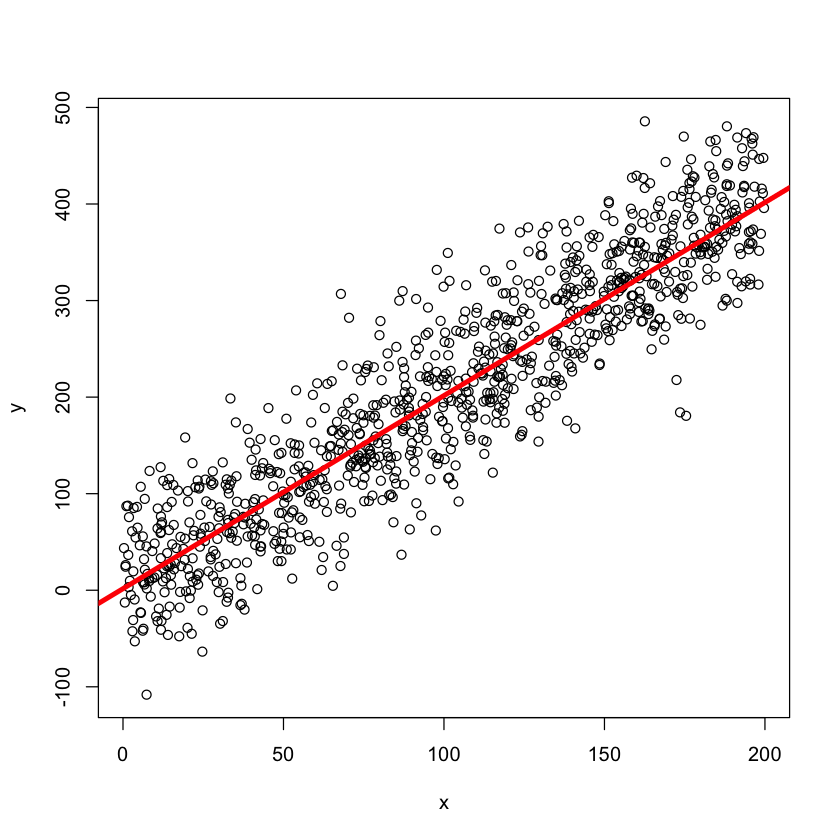

In [191]:

x <- runif(1000, 0, 200)
y <- x*2 + 3 + rnorm(1000, 0, 50)
plot(x, y)
head(x)
head(y)
abline(a = 1.61, b = 2, col = 'red', lwd = 4)

In [192]:
likelihood_function <- function(par){
    slope <- par[1]
    intercept <- par[2]
    y_pred <- x*slope + intercept
    rms <- log(mean(sqrt(((y_pred - y)^2))))
    return(rms)
}

In [193]:
likelihood_function(c(2, 3))
likelihood_function(c(2, 25))

[1] 3.692287

[1] 3.785231

In [194]:
mle <- optim(par = c(0, 0), fn = likelihood_function)
mle

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1]  2.050760 -3.222362

$value
[1] 3.689795

$counts
function gradient 
     125       NA 

$convergence
[1] 0

$message
NULL


## Bayesian mcmc

In [204]:
prior_function <- function(par){
    prior_slope <- dunif(par[1], -5, 5)#dnorm(par[1], 2, 1)
    prior_intercept <- dunif(par[2], -5, 5)#dnorm(par[2], 3, 1)
    return(log(prior_slope*prior_intercept))
}

prior_function_errors <- function(par){
    prior_slope <- dunif(par[1], -5, 5)#dnorm(par[1], 2, 1)
    prior_intercept <- dunif(par[2], -5, 5)#dnorm(par[2], 3, 1)
    prior_sd <- dunif(par[3], 0, 100)
    return(log(prior_slope*prior_intercept*prior_sd))
}

In [205]:
prior_function(c(1, 1))

[1] -4.60517

In [207]:
likelihood_function <- function(par){
    slope <- par[1]
    intercept <- par[2]
    y_pred <- x*slope + intercept
    rms <- -log(mean(sqrt(((y_pred - y)^2))))
    return(rms)
}

likelihood_function_errors <- function(par){
    slope <- par[1]
    intercept <- par[2]
    sd <- par[3]
    y_pred <- x*slope + intercept
    single_likelihoods <- dnorm(y, y_pred, sd = abs(sd), log = T)
    return(sum(single_likelihoods))
}

### MCMC

In [208]:
n_steps <- 1000000
start_par <- c(rnorm(2), runif(1))
start_likelihood <- likelihood_function_errors(start_par)
start_prior <- prior_function_errors(start_par)
start_posterior <- start_likelihood + start_prior

output_frame <- matrix(NA, n_steps, 7)
colnames(output_frame) <- c('step', 'likelihood', 'prior', 
                            'posterior', 'slope', 'intercept', 'sd')
output_frame[1, ] <- c(1, start_likelihood, start_prior, 
                       start_posterior, start_par[1], start_par[2], start_par[3])

head(output_frame)

step,likelihood,prior,posterior,slope,intercept,sd
1.000000e+00,-1.372835e+07,-9.210340e+00,-1.372836e+07,1.168397e+00,-2.014277e+00,6.980104e-01
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA


In [209]:
proposal_function <- function(par){
    return(c(par[1] + rnorm(1, 0, 0.2), par[2] + rnorm(1, 0, 0.2)))
}

proposal_function_errors <- function(par){
    return(c(par[1] + rnorm(1, 0, 0.5), par[2] + rnorm(1, 0, 0.1), abs(par[3]+rnorm(1, 0, 0.3))))
}

In [210]:
for(i in 2:n_steps){
    proposed_par <- proposal_function_errors(output_frame[i-1, c(5, 6, 7)])
    proposed_prior <- prior_function_errors(proposed_par)
    proposed_likelihood <- likelihood_function_errors(proposed_par)
    proposed_posterior <- proposed_prior + proposed_likelihood

    if(proposed_posterior > output_frame[i-1, 4]){
        output_frame[i, ] <- c(i, proposed_likelihood, proposed_prior,
                              proposed_posterior, proposed_par)
    }else{
        mh_ratio <- exp(proposed_posterior - output_frame[i-1, 4])
        if(mh_ratio > runif(1)){
                    output_frame[i, ] <- c(i, proposed_likelihood, proposed_prior,
                              proposed_posterior, proposed_par)
        }else{
            output_frame[i, ] <- output_frame[i-1, ]
        }
    }
}

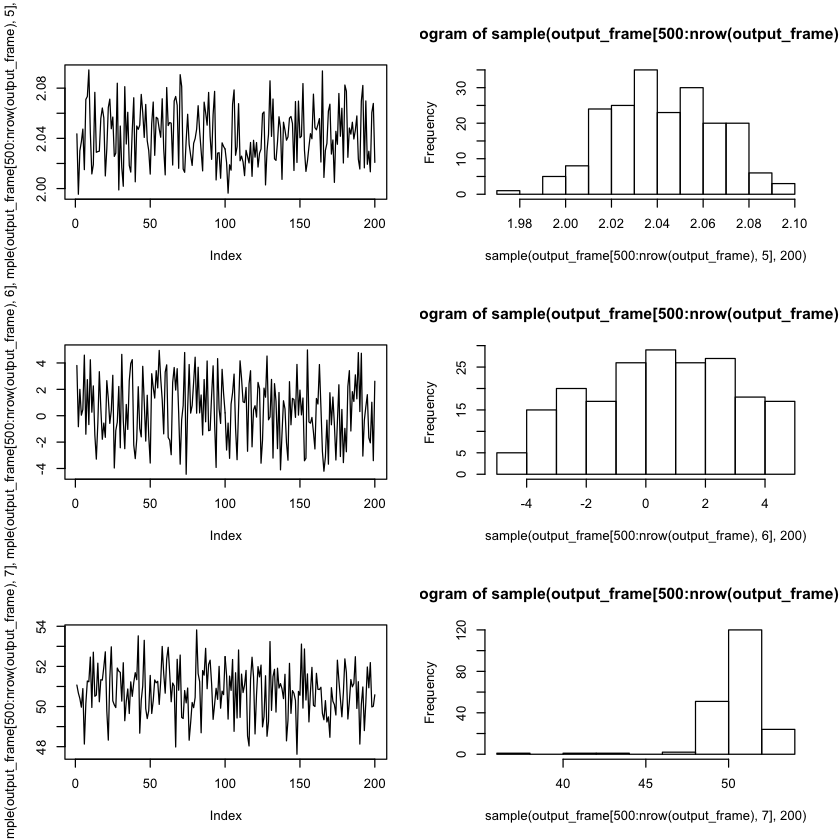

In [211]:
par(mfrow = c(3, 2))
plot(sample(output_frame[500:nrow(output_frame), 5], 200), type= 'l')
hist(sample(output_frame[500:nrow(output_frame), 5], 200))
plot(sample(output_frame[500:nrow(output_frame), 6], 200), type = 'l')
hist(sample(output_frame[500:nrow(output_frame), 6], 200))
plot(sample(output_frame[500:nrow(output_frame), 7], 200), type = 'l')
hist(sample(output_frame[500:nrow(output_frame), 7], 200))

In [212]:
colMeans(output_frame)
quantile(output_frame[, 5], c(0.025, 0.5, 0.975))
quantile(output_frame[, 6], c(0.025, 0.5, 0.975))
quantile(output_frame[, 7], c(0.025, 0.5, 0.975))

step    likelihood         prior     posterior         slope 
 4.999703e+05 -5.424840e+03 -9.210340e+00 -5.434051e+03  2.039889e+00 
    intercept            sd 
 5.887069e-01  5.061861e+01

2.5%      50%    97.5% 
1.997644 2.038902 2.086203

2.5%        50%      97.5% 
-4.1839405  0.8631657  4.6026730

2.5%      50%    97.5% 
48.44469 50.65898 53.02367

In [178]:
effectiveSize(output_frame)

step   likelihood        prior    posterior        slope    intercept 
2.294576e+00 7.868454e+05 0.000000e+00 7.868454e+05 2.493045e+02 3.726959e+01 
          sd 
4.217617e+01